## An example Python data analysis notebook

This page illustrates how to use Python to perform a simple but complete analysis: retrieve data, do some computations based on it, and visualise the results.

**Don't worry if you don't understand everything on this page!** Its purpose is to give you an example of things you can do and how to go about doing them - you are not expected to be able to reproduce an analysis like this in Python at this stage! We will be looking at the concepts and practices introduced on this page as we go along the course.

As we show the code for different parts of the work, we will be touching on various aspects you may want to keep in mind, either related to Python specifically, or to research programming more generally.

### Why write software to manage your data and plots? 

We can use programs for our entire research pipeline. Not just big scientific simulation codes, but also the small scripts which we use to tidy up data and produce plots. This should be code, so that the whole research pipeline
is recorded for reproducibility. Data manipulation in spreadsheets is much harder to share or 
check. 

You can see another similar demonstration on the [software carpentry site](https://swcarpentry.github.io/python-novice-inflammation/01-numpy/index.html). 
We'll try to give links to other sources of Python training along the way.
Part of our approach is that we assume you know how to use the internet! If you
find something confusing out there, please bring it along to the next session. In this course, we'll always try to draw your attention to other sources of information about what we're learning. Paying attention to as many of these as you need to, is just as important as these core notes.

### Importing Libraries

Research programming is all about using libraries: tools other people have provided programs that do many cool things.
By combining them we can feel really powerful but doing minimum work ourselves. The python syntax to import someone else's library is "import".

In [2]:
import geopy # A python library for investigating geographic information.
# https://pypi.org/project/geopy/

Now, if you try to follow along on this example in an Jupyter notebook, you'll probably find that 
you just got an error message.

You'll need to wait until we've covered installation of additional python libraries later in the course, then come
back to this and try again. For now, just follow along and try get the feel for how programming for data-focused
research works.

In [7]:
geocoder = geopy.geocoders.Nominatim(user_agent="mphy0021")
geocoder.geocode('Cambridge', exactly_one=False)

[Location(Cambridge, Cambridgeshire, East of England, England, United Kingdom, (52.2034823, 0.1235817, 0.0)),
 Location(Cambridge, Cambridgeshire, East of England, England, United Kingdom, (52.2034823, 0.1235817, 0.0)),
 Location(Cambridge, Middlesex County, Massachusetts, United States of America, (42.3750997, -71.1056157, 0.0)),
 Location(Cambridge, Waterloo Region, Southwestern Ontario, Ontario, N1R 1T7, Canada, (43.3600536, -80.3123023, 0.0)),
 Location(Cambridge, Henry County, Illinois, United States of America, (41.3036472, -90.1928971, 0.0)),
 Location(Cambridge, Isanti County, Minnesota, 55008, United States of America, (45.5727408, -93.2243921, 0.0)),
 Location(Cambridge, Story County, Iowa, 50046, United States of America, (41.8990768, -93.5294029, 0.0)),
 Location(Cambridge, Dorchester County, Maryland, 21613, United States of America, (38.5714624, -76.0763177, 0.0)),
 Location(Cambridge, Guernsey County, Ohio, 43725, United States of America, (40.031183, -81.5884561, 0.0)),

The results come out as a **list** inside a list: `[Name, [Latitude, Longitude]]`. 
Programs represent data in a variety of different containers like this.

### Comments

Code after a `#` symbol doesn't get run.

In [3]:
print("This runs") # print("This doesn't")
# print("This doesn't either")

This runs


### Functions

We can wrap code up in a **function**, so that we can repeatedly get just the information we want.


In [4]:
def geolocate(place):
    return geocoder.geocode(place, exactly_one = False)[0][1]

Defining **functions** which put together code to make a more complex task seem simple from the outside is the most important thing in programming. The output of the function is stated by "return"; the input comes in in brackets after the function name:


In [5]:
geolocate('Cambridge')

(52.2053855332241, 0.12181995849728)

### Variables

We can store a result in a variable:

In [6]:
london_location = geolocate("London")
print(london_location)

(51.5073584389643, -0.12775209319198)


### More complex functions

We'll fetch a map of a place from the Google Maps server, given a longitude and latitude.
The URLs look like: https://mt0.google.com/vt?x=658&y=340&z=10&lyrs=s.    
The latitude & longitude need to be translated to the coordinate system used by Google Maps and we'll frequently be generating these URLs.
So we'll make ourselves another function to build up a request from the URL given our parameters.

In [7]:
import os
import math
import requests

def request_map_at(lat, long, zoom=10, satellite=True):
    
    base_url = "https://mt0.google.com/vt?"
    
    gmaps_tile_size = 256
    num_tiles = 1 << zoom
    
    x_coord = (gmaps_tile_size / 2 + lat * gmaps_tile_size / 360.0) * num_tiles // gmaps_tile_size
    sin_y = math.sin(lat * (math.pi / 180.0))  
    y_coord = ((gmaps_tile_size / 2) + 0.5 * math.log((1 + sin_y) / (1 - sin_y)) * 
               -(gmaps_tile_size / (2 * math.pi))) * num_tiles // gmaps_tile_size

    params = dict(
        x=int(x_coord),
        y=int(y_coord),
        z=zoom
    )
    if satellite:
        params['lyrs'] = 's'

    return requests.get(base_url, params=params)

In [8]:
map_response = request_map_at(51.5072, -0.1275)

### Checking our work

Let's see what URL we ended up with:

In [14]:
url = map_response.url
print(url[0:25])
print(url[25:])

https://mt0.google.com/vt
?x=658&y=340&z=10&lyrs=s


We can write **automated tests** so that if we change our code later, we can check the results are still valid.

In [15]:
assert "https://mt0.google.com/vt?" in url
assert "z=10" in url
assert "lyrs=s" in url

Our previous function comes back with an Object representing the web request. In object oriented programming, we use the .
operator to get access to a particular **property** of the object, in this case, the actual image at that URL is in the `content` property. It's a big file, so I'll just get the first few bytes:

In [16]:
map_response.content[0:20]

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'

### Displaying results

I'll need to do this a lot, so I'll wrap up our previous function in another function, to save on typing.

In [17]:
def map_at(*args, **kwargs):
    return request_map_at(*args, **kwargs).content

I can use a library that comes with Jupyter notebook to display the image. Being able to work with variables which contain images, or documents, or any other weird kind of data, just as easily as we can with numbers or letters, is one of the really powerful things about modern programming languages like Python. 

In [18]:
import IPython
map_png = map_at(*london_location)

In [19]:
print("The type of our map result is actually a: ", type(map_png))

The type of our map result is actually a:  <class 'bytes'>


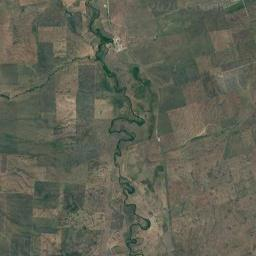

In [20]:
IPython.core.display.Image(map_png)

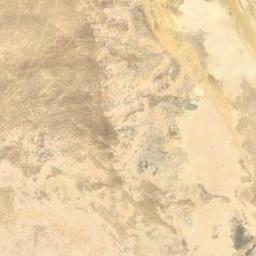

In [21]:
IPython.core.display.Image(map_at(*geolocate("New Delhi")))

### Manipulating Numbers

Now we get to our research project: we want to find out how urbanised the world is, based on satellite imagery, along a line
    between two cites. We expect the satellite image to be greener in the countryside.

We'll use lots more libraries to count how much green there is in an image.

In [22]:
from io import BytesIO # A library to convert between files and strings
import numpy as np # A library to deal with matrices
import imageio # A library to deal with images

Let's define what we count as green:

In [23]:
def is_green(pixels):
    threshold = 1.1
    greener_than_red = pixels[:,:,1] > threshold * pixels[:,:,0]
    greener_than_blue = pixels[:,:,1] > threshold * pixels[:,:,2]
    green = np.logical_and(greener_than_red, greener_than_blue) 
    return green

This code has assumed we have our pixel data for the image as a $256 \times 256 \times 3$ 3-d matrix,
with each of the three layers being red, green, and blue pixels.

We find out which pixels are green by comparing, element-by-element, the middle (green, number 1) layer to the top (red, zero) and bottom (blue, 2)

Now we just need to parse in our data, which is a PNG image, and turn it into our matrix format:

In [24]:
def count_green_in_png(data):
    f = BytesIO(data)
    pixels = imageio.imread(f) # Get our PNG image as a numpy array
    return np.sum(is_green(pixels))

In [25]:
print(count_green_in_png( map_at(*london_location) ))

13903


We'll also need a function to get an evenly spaced set of places between two endpoints:

In [26]:
def location_sequence(start, end, steps):
    lats = np.linspace(start[0], end[0], steps) # "Linearly spaced" data
    longs = np.linspace(start[1], end[1], steps)
    return np.vstack([lats, longs]).transpose()

In [27]:
location_sequence(geolocate("London"), geolocate("Cambridge"), 5)

array([[ 5.15073584e+01, -1.27752093e-01],
       [ 5.16818652e+01, -6.53590803e-02],
       [ 5.18563720e+01, -2.96606735e-03],
       [ 5.20308788e+01,  5.94269456e-02],
       [ 5.22053855e+01,  1.21819958e-01]])

### Creating Images

We should display the green content to check our work:

In [28]:
def show_green_in_png(data):
    pixels = imageio.imread(BytesIO(data)) # Get our PNG image as rows of pixels
    green = is_green(pixels)

    out = green[:, :, np.newaxis] * np.array([0, 1, 0])[np.newaxis, np.newaxis, :]    

    buffer = BytesIO()
    result = imageio.imwrite(buffer, out, format='png')
    return buffer.getvalue()

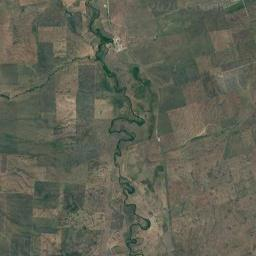

In [29]:
IPython.core.display.Image(
    map_at(*london_location, satellite=True)
)

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


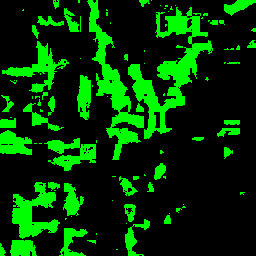

In [30]:
IPython.core.display.Image(
    show_green_in_png(
        map_at(
            *london_location,
            satellite=True)))

### Looping

We can loop over each element in out list of coordinates, and get a map for that place:

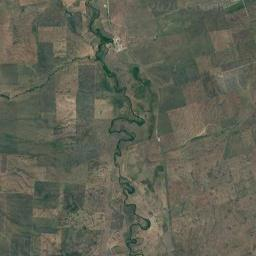

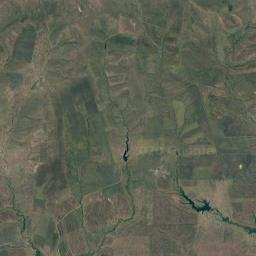

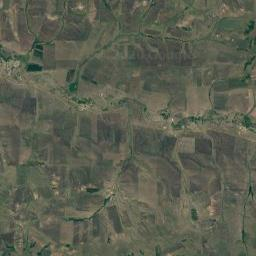

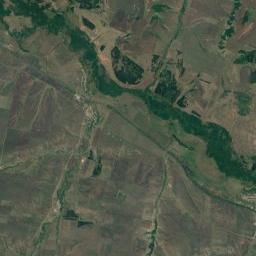

In [31]:
for location in location_sequence(geolocate("London"), 
                                  geolocate("Birmingham"),
                                  4):
    IPython.core.display.display( 
        IPython.core.display.Image(map_at(*location)))

So now we can count the green from London to Birmingham!

In [32]:
[count_green_in_png(map_at(*location))
            for location in 
                 location_sequence(geolocate("London"),
                                   geolocate("Birmingham"),
                                   10)]

[13903, 13903, 12954, 12954, 17691, 12352, 12919, 19399, 19399, 24053]

### Plotting graphs

Let's plot a graph.

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

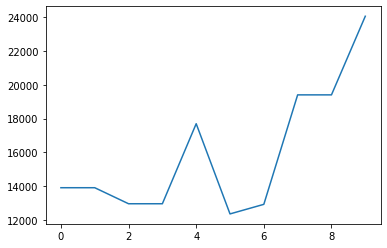

In [34]:
plt.plot([count_green_in_png(map_at(*location))
            for location in 
              location_sequence(geolocate("London"), 
                                geolocate("Birmingham"), 
                                10)])

From a research perspective, of course, this code needs a lot of work. But I hope the power of using programming is clear.


### Composing Program Elements

We built little pieces of useful code, to:

* Find latitude and longitude of a place
* Get a map at a given latitude and longitude
* Decide whether a (red,green,blue) triple is mainly green
* Decide whether each pixel is mainly green
* Plot a new image showing the green places
* Find evenly spaced points between two places

By putting these together, we can make a function which can plot this graph automatically for any two places:

In [35]:
def green_between(start, end,steps):
    return [count_green_in_png( map_at(*location) )
            for location in location_sequence(
                            geolocate(start),
                            geolocate(end),
                            steps)]

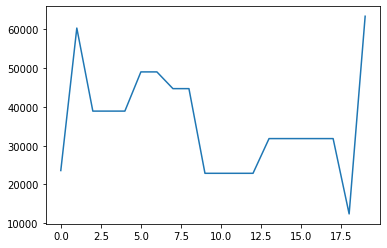

In [36]:
plt.plot(green_between('New York', 'Chicago', 20))

And that's it! We've covered, very very quickly, the majority of the python language, and much of the theory of software engineering.

Now we'll go back, carefully, through all the concepts we touched on, and learn how to use them properly ourselves.